Import libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.__version__

'2.3.3'

Load dataset

In [5]:
df = pd.read_csv("../data/Titanic-Dataset.csv")
df.shape

(891, 12)

Simple EDA

In [6]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Data Cleaning

In [7]:
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

df = df.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


Train / Val / Test Split

In [8]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

Prepare Target and Dictionaries

In [9]:
y_train = df_train.Survived.values
y_val = df_val.Survived.values
y_test = df_test.Survived.values

train_dicts = df_train.drop("Survived", axis=1).to_dict(orient="records")
val_dicts = df_val.drop("Survived", axis=1).to_dict(orient="records")
test_dicts = df_test.drop("Survived", axis=1).to_dict(orient="records")


Vectorize Features

In [10]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=True)

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)
X_test = dv.transform(test_dicts)


Logistic Regression

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr = LogisticRegression(max_iter=500)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_val)
acc_lr = accuracy_score(y_val, y_pred_lr)

acc_lr


0.7865168539325843

Decision Tree

In [10]:
from sklearn.tree import DecisionTreeClassifier

acc_dt_list = {}

for d in [3, 5, 7, 10, None]:
    dt = DecisionTreeClassifier(max_depth=d, random_state=1)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_val)
    acc_dt_list[d] = accuracy_score(y_val, y_pred)

acc_dt = acc_dt_list[3]  # best depth
acc_dt


0.8258426966292135

Random Forest

In [11]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=1)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_val)
acc_rf = accuracy_score(y_val, y_pred_rf)

acc_rf


0.8258426966292135

Gradient Boosting

In [12]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=1)
gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_val)
acc_gb = accuracy_score(y_val, y_pred_gb)

acc_gb


0.797752808988764

XGBoost

In [13]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

params = {
    'eta': 0.1,
    'max_depth': 6,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}

model_xgb = xgb.train(params, dtrain, num_boost_round=200)

y_pred_xgb = model_xgb.predict(dval)
y_pred_xgb_bin = (y_pred_xgb >= 0.5).astype(int)

acc_xgb = accuracy_score(y_val, y_pred_xgb_bin)

acc_xgb


0.8426966292134831

Compare All Models (Table)

In [14]:
results = {
    "Logistic Regression": acc_lr,
    "Decision Tree": acc_dt,
    "Random Forest": acc_rf,
    "Gradient Boosting": acc_gb,
    "XGBoost": acc_xgb
}

results


{'Logistic Regression': 0.7865168539325843,
 'Decision Tree': 0.8258426966292135,
 'Random Forest': 0.8258426966292135,
 'Gradient Boosting': 0.797752808988764,
 'XGBoost': 0.8426966292134831}

Plot Model Comparison

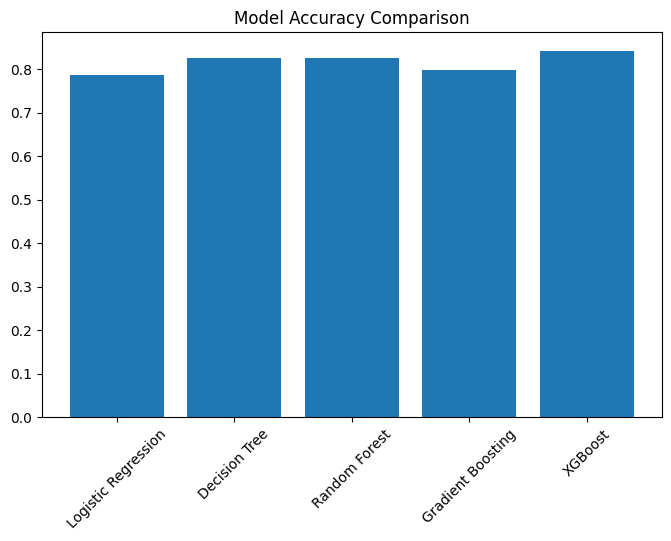

In [22]:
plt.figure(figsize=(8,5))
plt.bar(results.keys(), results.values())
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=45)
plt.show()


Retrain Best Model (XGBoost) on Full Train + Val

In [16]:
X_full_train = xgb.DMatrix(
    data = np.vstack([X_train.toarray(), X_val.toarray()]),
    label = np.concatenate([y_train, y_val])
)

best_params = {
    'eta': 0.1,
    'max_depth': 4,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}

model_final = xgb.train(best_params, X_full_train, num_boost_round=200)


Evaluate on Test Set

In [17]:
dtest = xgb.DMatrix(X_test)
y_pred = model_final.predict(dtest)
y_pred_binary = (y_pred >= 0.5).astype(int)

test_accuracy = accuracy_score(y_test, y_pred_binary)
test_accuracy


0.6089385474860335

In [23]:
dv.get_feature_names_out()

array(['Age', 'Embarked=C', 'Embarked=Q', 'Embarked=S', 'Fare', 'Parch',
       'Pclass', 'Sex=female', 'Sex=male', 'SibSp'], dtype=object)

In [24]:
feature_names = dv.get_feature_names_out()

for i, name in enumerate(feature_names):
    print(f"f{i} -> {name}")


f0 -> Age
f1 -> Embarked=C
f2 -> Embarked=Q
f3 -> Embarked=S
f4 -> Fare
f5 -> Parch
f6 -> Pclass
f7 -> Sex=female
f8 -> Sex=male
f9 -> SibSp


Plot Feature Importance

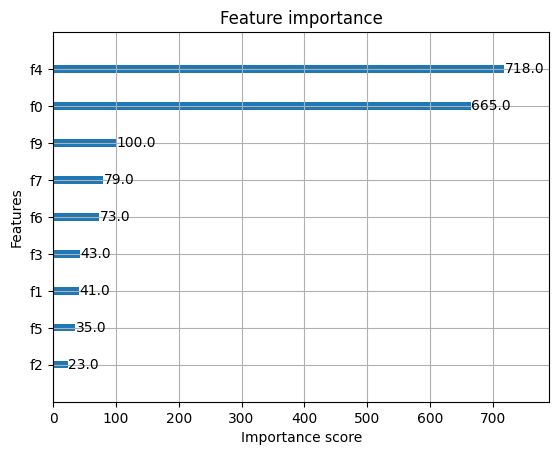

In [25]:
xgb.plot_importance(model_final, max_num_features=15)
plt.show()


In [28]:
def predict_passenger(model, dv, passenger):
    X = dv.transform([passenger])
    dX = xgb.DMatrix(X)
    pred = model.predict(dX)[0]
    return {
        "probability_survive": float(pred),
        "survived": int(pred >= 0.5)
    }


In [29]:
person = {
    "Pclass": 1,
    "Sex": "female",
    "Age": 30,
    "SibSp": 0,
    "Parch": 0,
    "Fare": 80,
    "Embarked": "C"
}

predict_passenger(model_final, dv, person)

{'probability_survive': 0.995730459690094, 'survived': 1}